In [1]:
import sys

import os
import matplotlib.pyplot as plt 

sys.path.append(os.path.abspath('../src'))

In [2]:
from load_utils import load_step_data
from utils import plot_raster_simple


In [3]:
step_data = load_step_data(
    base_dir='../src/save/ER_dense_stdp',
    step=8,
    arrays=['base_S_hist','pruned_S_hist_batch', 'removed_ids', 'neuron_type'])


In [4]:
step_data['metadata']['parameters']['N']

200

In [5]:
step_data['arrays'].keys()


dict_keys(['base_S_hist', 'pruned_S_hist_batch', 'removed_ids', 'neuron_type'])

(<Figure size 1440x450 with 1 Axes>,
 <Axes: xlabel='Time (ms)', ylabel='Neuron ID'>)

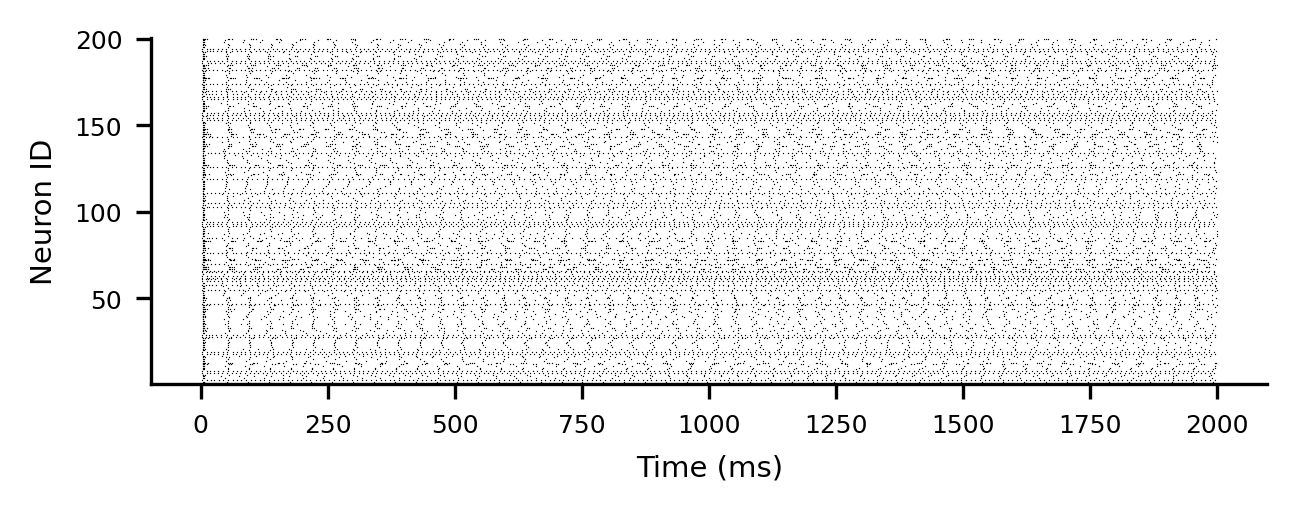

In [6]:
plot_raster_simple(step_data['arrays']['base_S_hist'], 2000, title='', apply_style=True)

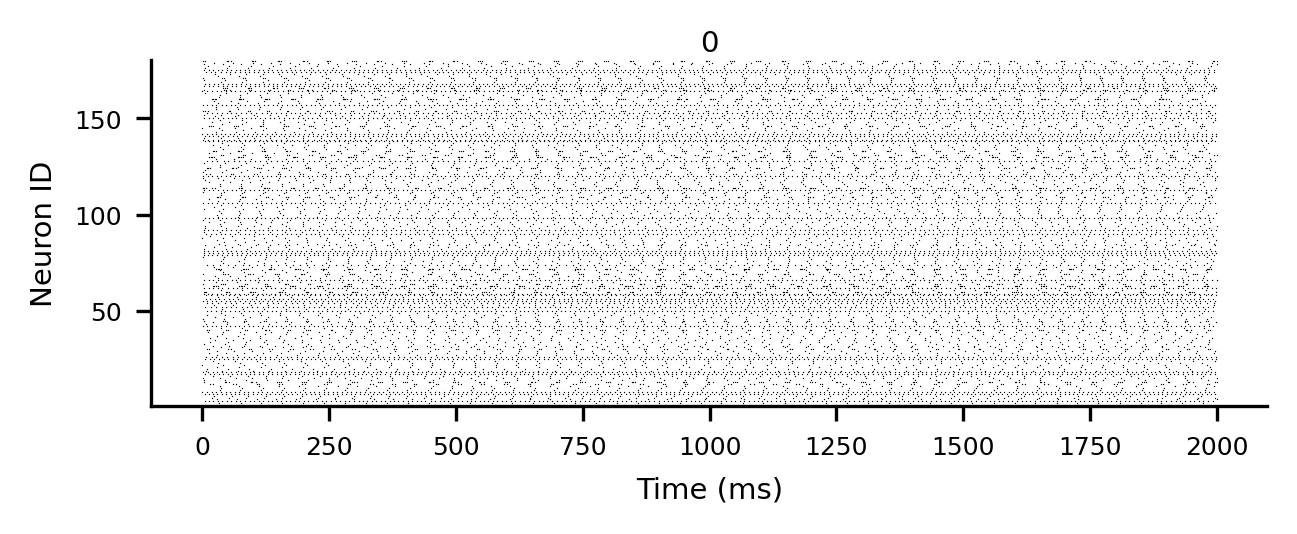

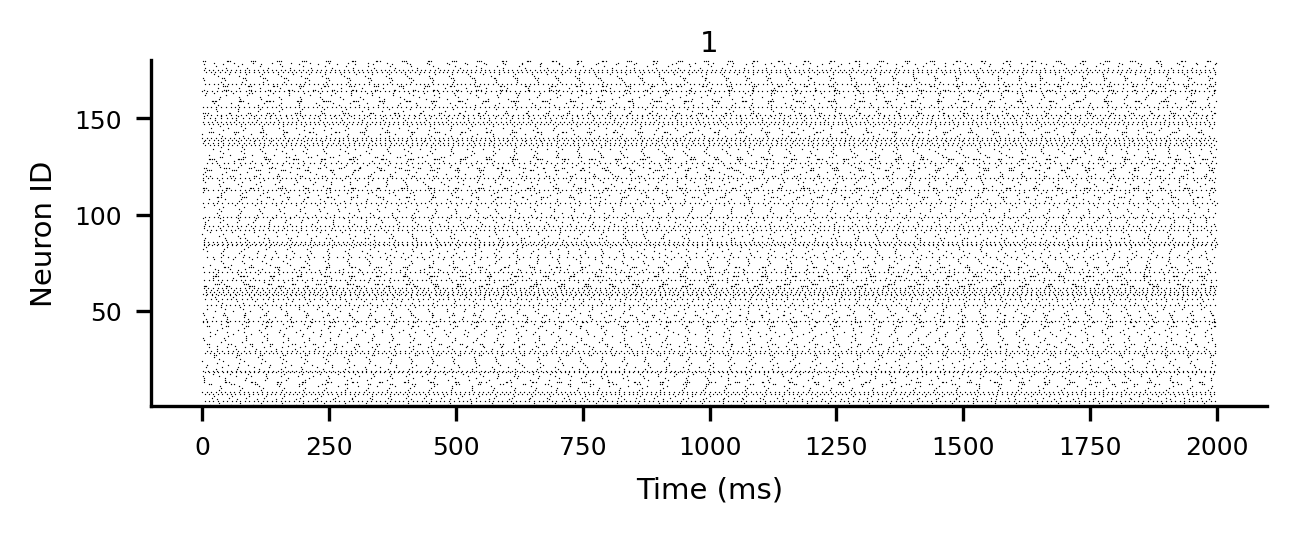

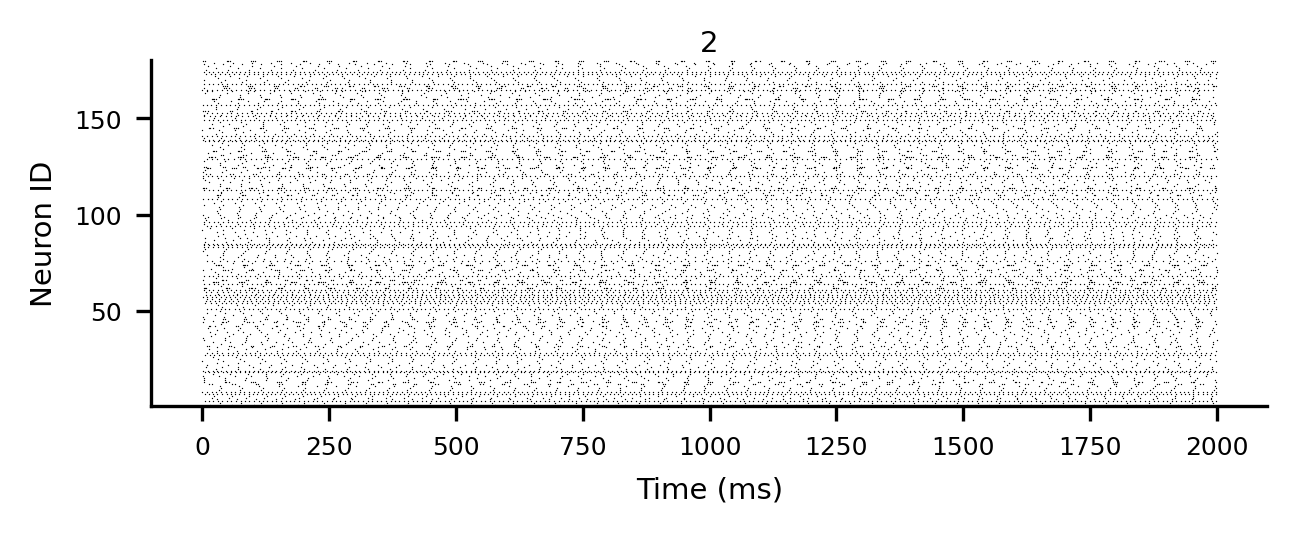

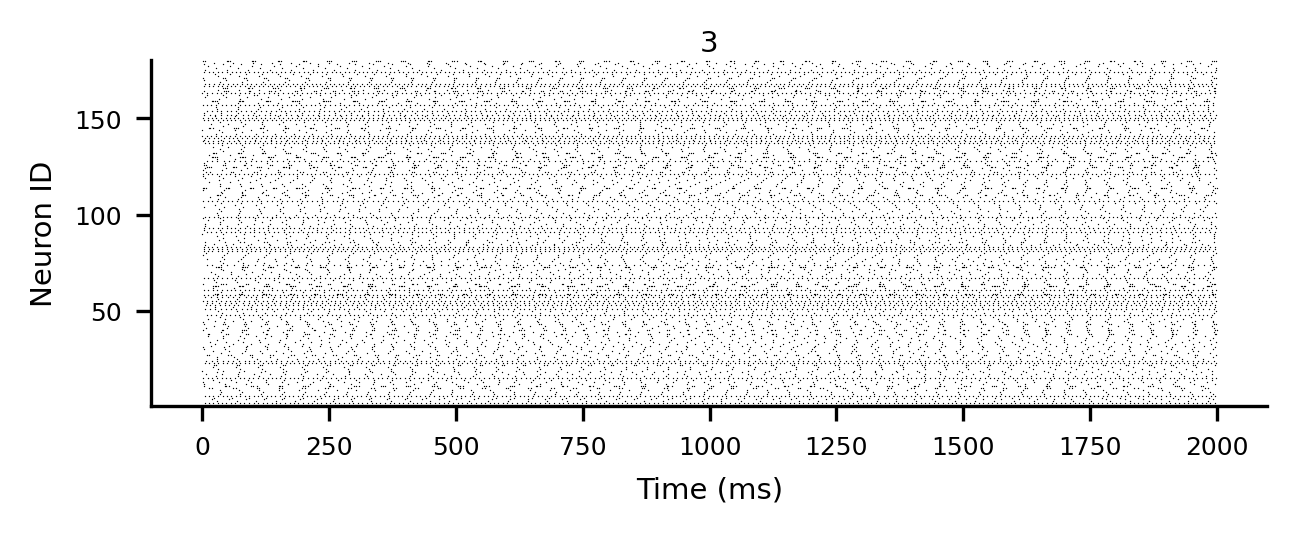

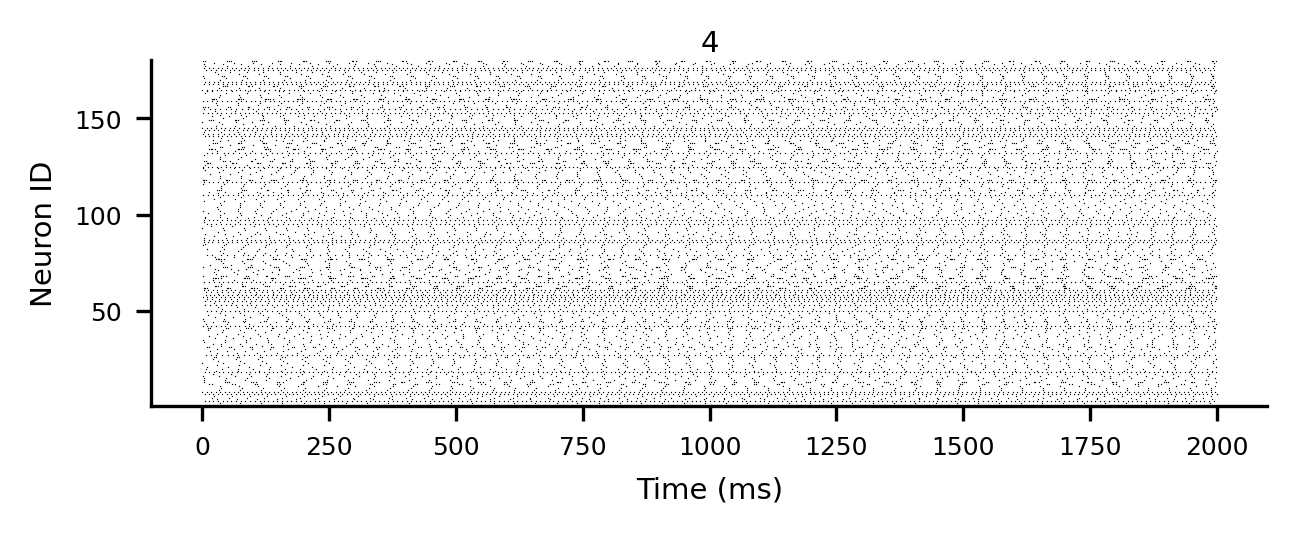

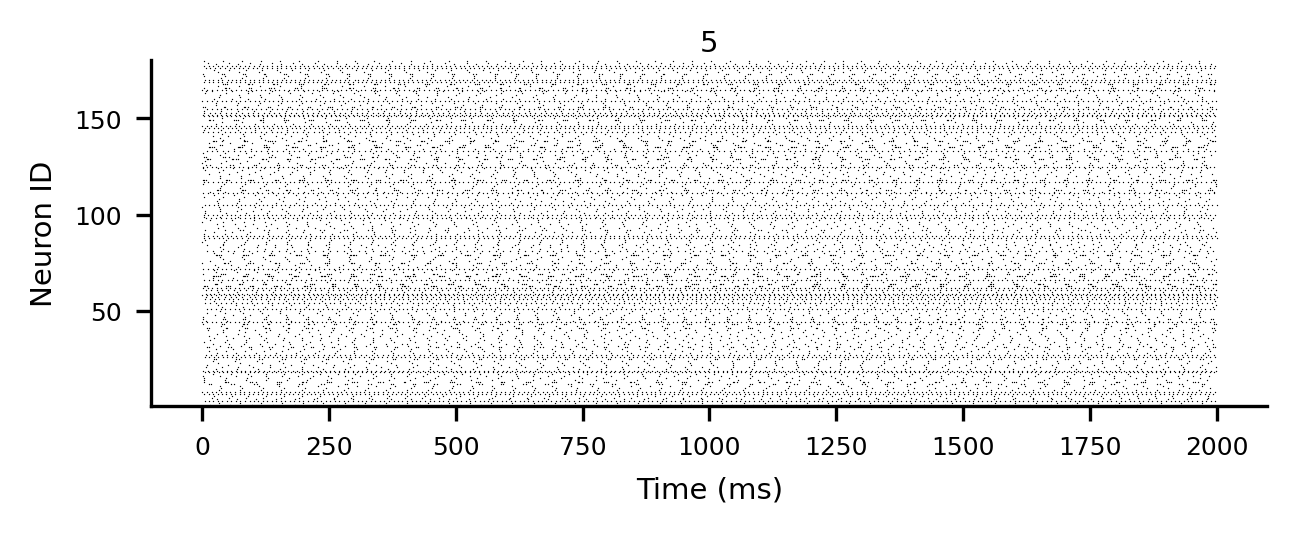

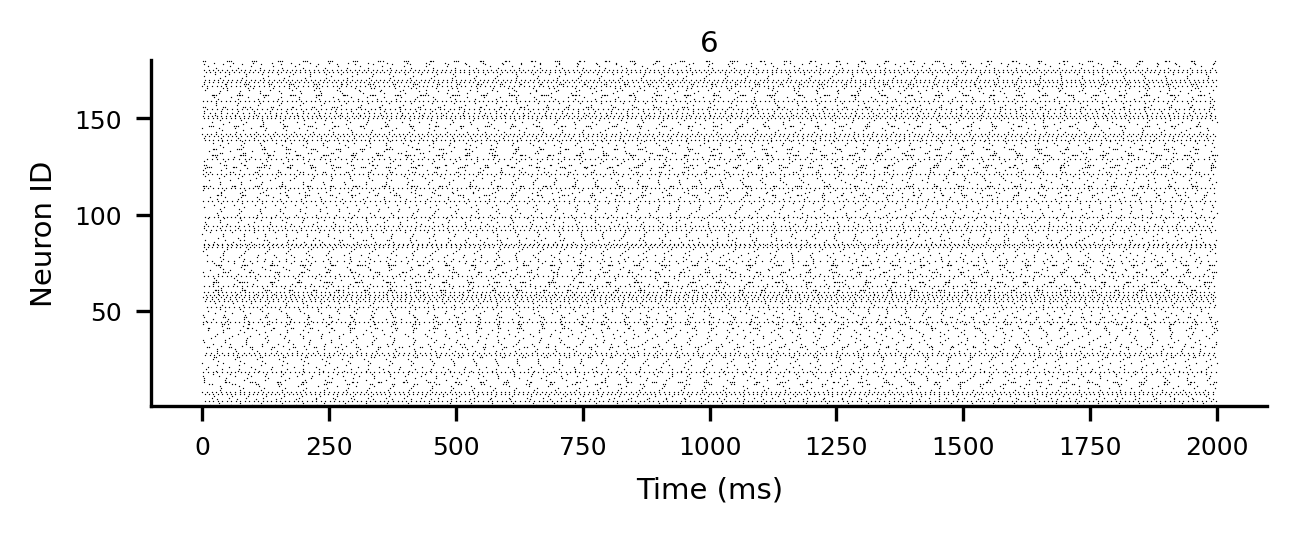

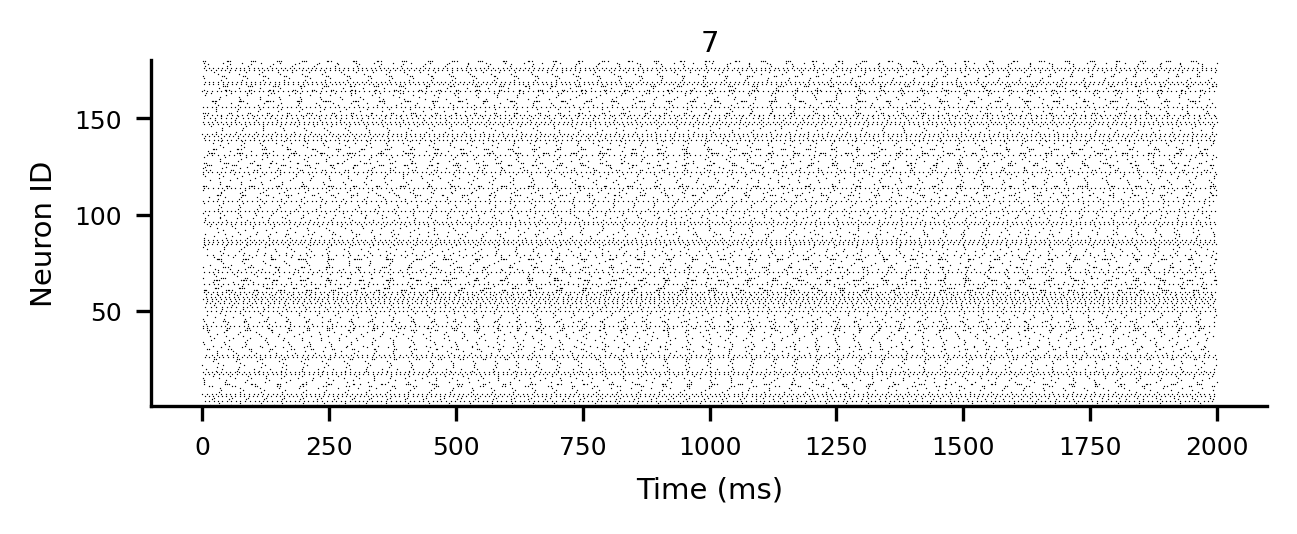

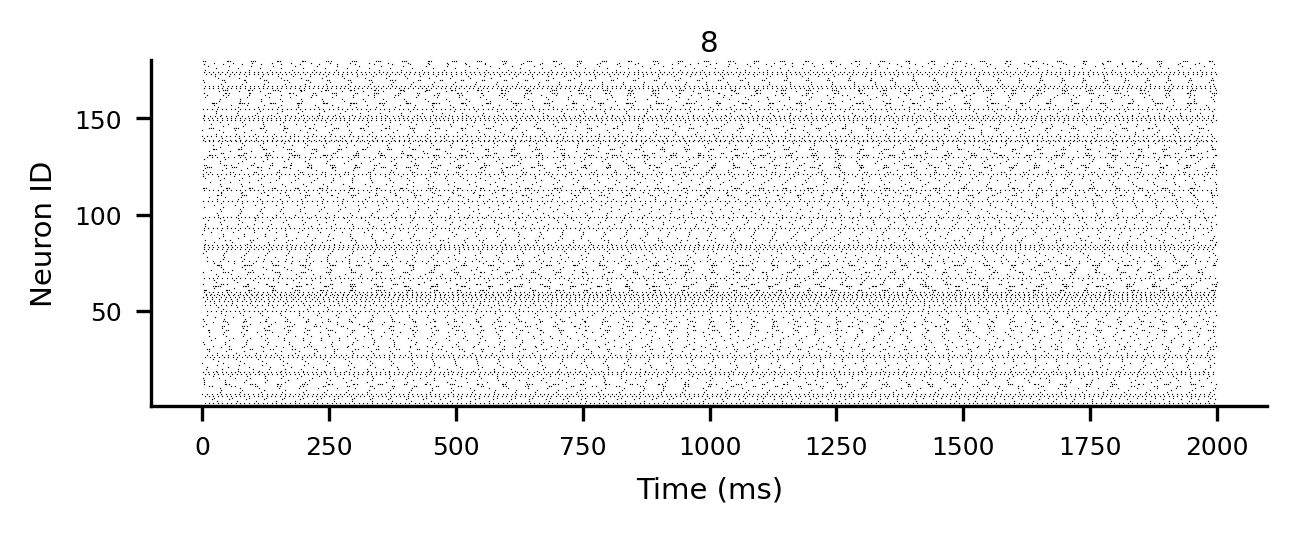

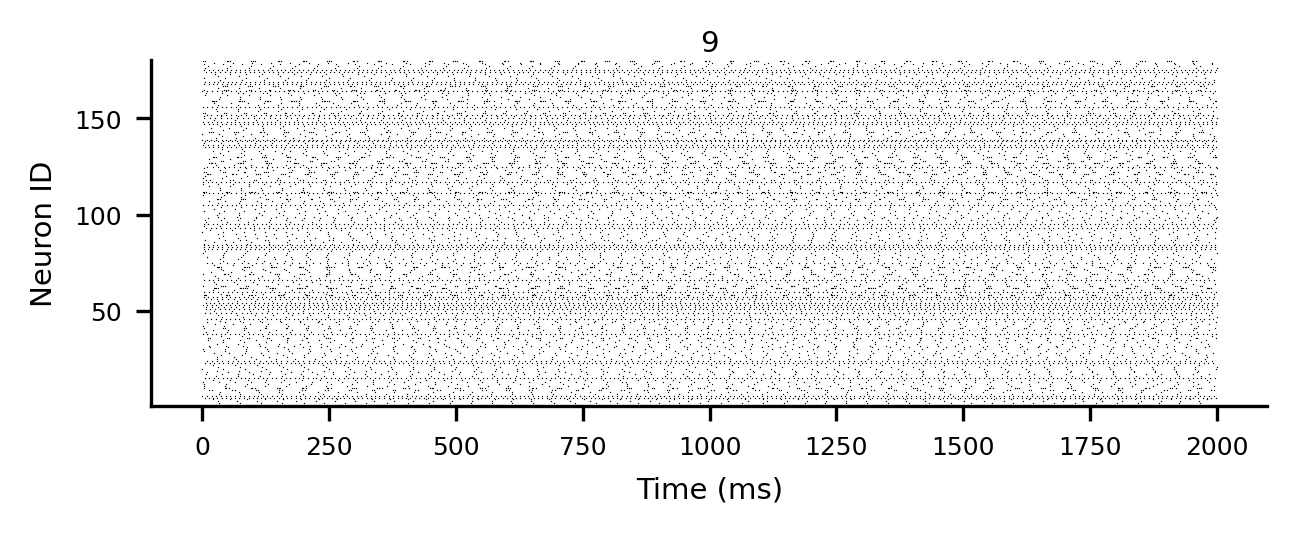

In [7]:
for n in range(10):
    plot_raster_simple(step_data['arrays']['pruned_S_hist_batch'][n], 2000, title=f'{n}', apply_style=True)

In [8]:
import numpy as np

def keep_indices(remove_idx: np.ndarray, N: int) -> np.ndarray:
    """Return fixed-size (N-k,) indices to keep. O(N)."""
    k = remove_idx.shape[0]
    # mask: True for keep, False for remove
    mask = np.ones((N,), dtype=bool)
    mask[remove_idx] = False
    # Grab exactly N-k kept indices, preserving order (left→right).
    keep_idx = np.nonzero(mask)[0]  # (N-k,)
    return keep_idx

def _take_vec(x: np.ndarray, idx: np.ndarray) -> np.ndarray:
    return np.take(x, idx, axis=0)

def _take_square(M: np.ndarray, idx: np.ndarray) -> np.ndarray:
    M1 = np.take(M, idx, axis=0)
    M2 = np.take(M1, idx, axis=1)
    return M2

In [9]:

step_data['arrays']['removed_ids'][0]

array([ 67,  59,  90,  74, 165,  56, 167, 180,  36, 138,  13,  79,  45,
        26,  87,  70,  19, 195, 130, 183], dtype=int32)

In [10]:
S_hist_R = step_data['arrays']['pruned_S_hist_batch']
S_hist_R[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(8000, 180))

In [11]:
import infomeasure as im
import antropy as ant
import numpy as np
import networkx as nx

im_args = {"approach": "miller_madow", "base": 2}
batch = 0
fraction = 0.33
N = step_data['metadata']['parameters']['N']

S_hist = step_data['arrays']['base_S_hist']
S_hist_R = step_data['arrays']['pruned_S_hist_batch'][batch]

test_fraction = int(len(S_hist) * fraction)

surviving_nodes = keep_indices(step_data['arrays']['removed_ids'][batch], N)
A = S_hist[-test_fraction:, surviving_nodes]
B = S_hist_R[:test_fraction]
C = S_hist_R[-test_fraction:]

# Entropy of network microstates (rows = time, columns = neurons)
h_A = im.entropy(A, **im_args)
h_B = im.entropy(B, **im_args)
h_C = im.entropy(C, **im_args)

In [12]:
test_fraction

2640

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:01<00:00, 34.49it/s]


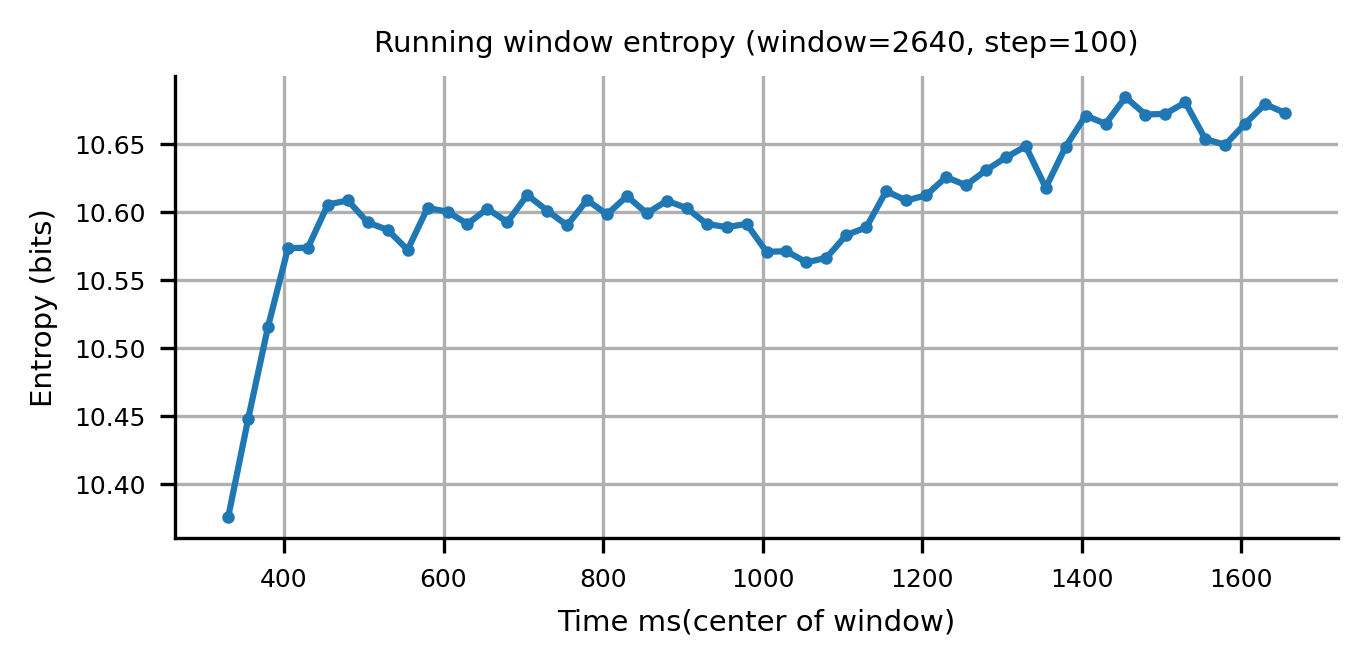

In [13]:
from tqdm import tqdm 

window_size = test_fraction
step_size = 100

entropies = []
times = []

im_args = {"approach": "miller_madow", "base": 2}


A = S_hist

# Determine time axis from number of timesteps
T_total = 2000
T = A.shape[0]
dt = T_total / T
real_time_axis = np.arange(T) * dt

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A[start:start+window_size]
    H = im.entropy(window, **im_args)
    entropies.append(H)
    center_idx = start + window_size // 2
    times.append(real_time_axis[center_idx])

# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=2)
plt.xlabel("Time ms(center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

In [14]:
A

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(8000, 200))

In [17]:

post_batch_entropies = []
post_batch_times = []

for batch in range(10):
    entropies = []
    times = []

    surviving_nodes = keep_indices(step_data['arrays']['removed_ids'][batch], N)
    A = step_data['arrays']['base_S_hist']
    A = A[:, surviving_nodes]
    im_args = {"approach": "miller_madow", "base": 2}

    B = step_data['arrays']['pruned_S_hist_batch'][batch]
    A = np.concatenate([A,B], axis=0)
    for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
        window = A[start:start+window_size]
        H = im.entropy(window, **im_args)
        entropies.append(H)
        # Offset post times so they start after pre
        times.append(times[-1] + (start + window_size//2) if times else (start + window_size//2))
    post_batch_entropies.append(entropies)
    post_batch_times.append(times)



100%|██████████| 134/134 [00:03<00:00, 36.41it/s]


In [16]:
import multiprocessing as mp
from tqdm import tqdm
import numpy as np

def process_batch(batch):
    entropies = []
    times = []

    # Select surviving nodes
    surviving_nodes = keep_indices(step_data['arrays']['removed_ids'][batch], N)

    # Build data matrix
    A = step_data['arrays']['base_S_hist']
    A = A[:, surviving_nodes]
    B = step_data['arrays']['pruned_S_hist_batch'][batch]
    A = np.concatenate([A, B], axis=0)

    # Time axis for this batch
    T_total = 4000   # or whatever your experiment duration is
    T = A.shape[0]
    dt = T_total / T
    real_time_axis = np.arange(T) * dt

    # Info-theory args
    im_args = {"approach": "miller_madow", "base": 2}

    # Sliding window entropy
    for start in range(0, A.shape[0] - window_size + 1, step_size):
        window = A[start:start+window_size]
        H = im.entropy(window, **im_args)
        entropies.append(H)

        center_idx = start + window_size // 2
        times.append(real_time_axis[center_idx])

    return entropies, times


# Parallel execution
with mp.Pool(processes=mp.cpu_count()) as pool:
    results = list(tqdm(pool.imap(process_batch, range(10)), total=10, desc="Batches"))

# Unpack results
post_batch_entropies, post_batch_times = zip(*results)
post_batch_entropies = list(post_batch_entropies)
post_batch_times = list(post_batch_times)


Process SpawnPoolWorker-1:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mauffee/.local/share/mamba/envs/myenv/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/Users/mauffee/.local/share/mamba/envs/myenv/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mauffee/.local/share/mamba/envs/myenv/lib/python3.13/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/mauffee/.local/share/mamba/envs/myenv/lib/python3.13/multiprocessing/queues.py", line 387, in get
    return _ForkingPickler.loads(res)
           ~~~~~~~~~~~~~~~~~~~~~^^^^^
AttributeError: Can't get attribute 'process_batch' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
  File "/Users/m

KeyboardInterrupt: 

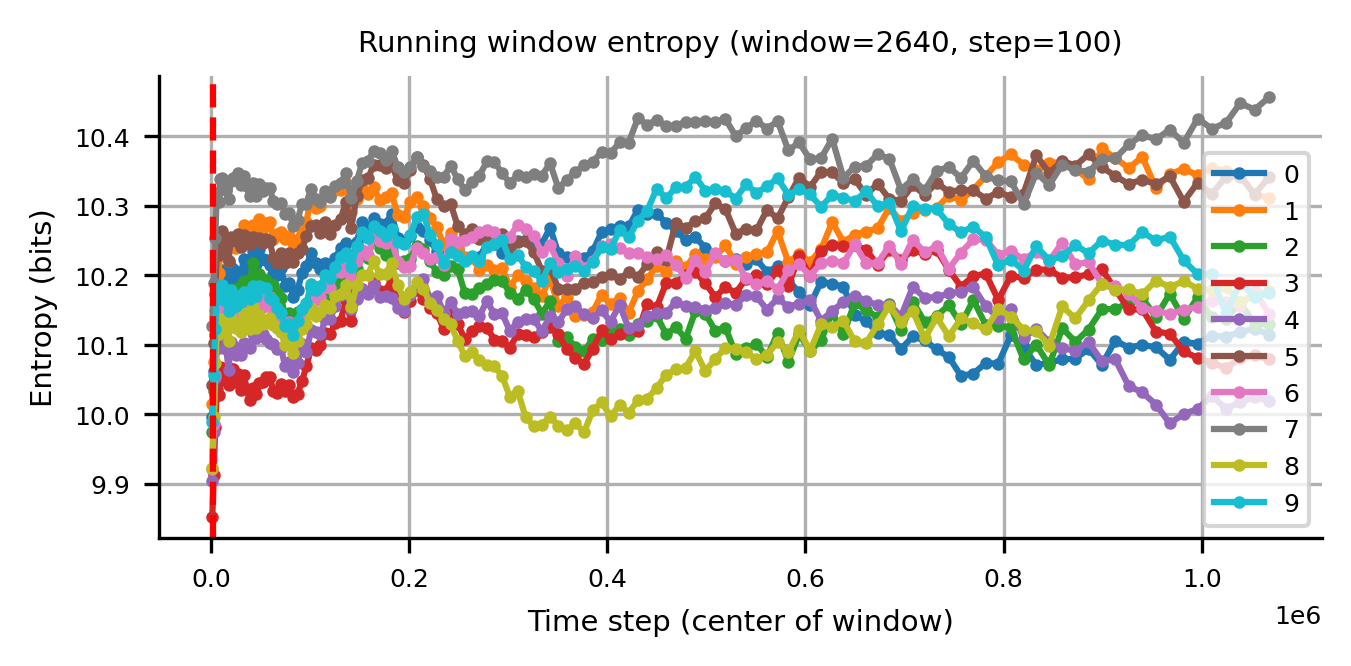

In [30]:
# Plot
plt.figure(figsize=(5,2))
for batch in range(10):
    plt.plot(post_batch_times[batch], post_batch_entropies[batch], marker='o', markersize=2, label=f'{batch}')


   # plt.plot(pre_batch_times[batch], pre_batch_entropies[batch], marker='o', markersize=2)
plt.axvline(2000, color='red', linestyle='--')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.legend()
plt.grid(True)
plt.show()

In [19]:


import numpy as np

# Stack all batches to shape (num_batches, num_timepoints)
# First, pad shorter arrays with np.nan so all are the same length
max_len = max(len(x) for x in post_batch_entropies)
entropy_mat = np.full((len(post_batch_entropies), max_len), np.nan)
for i, arr in enumerate(post_batch_entropies):
    entropy_mat[i, :len(arr)] = arr

# Compute mean and 95% bootstrap CIs at each timepoint
n_boot = 1000
means = np.nanmean(entropy_mat, axis=0)
cis_low = []
cis_high = []

rng = np.random.default_rng(seed=42)
for t in range(entropy_mat.shape[1]):
    vals = entropy_mat[:, t]
    vals = vals[~np.isnan(vals)]
    if len(vals) == 0:
        cis_low.append(np.nan)
        cis_high.append(np.nan)
        continue
    boots = rng.choice(vals, size=(n_boot, len(vals)), replace=True)
    boots_mean = np.mean(boots, axis=1)
    cis_low.append(np.percentile(boots_mean, 2.5))
    cis_high.append(np.percentile(boots_mean, 97.5))


# ...existing code...

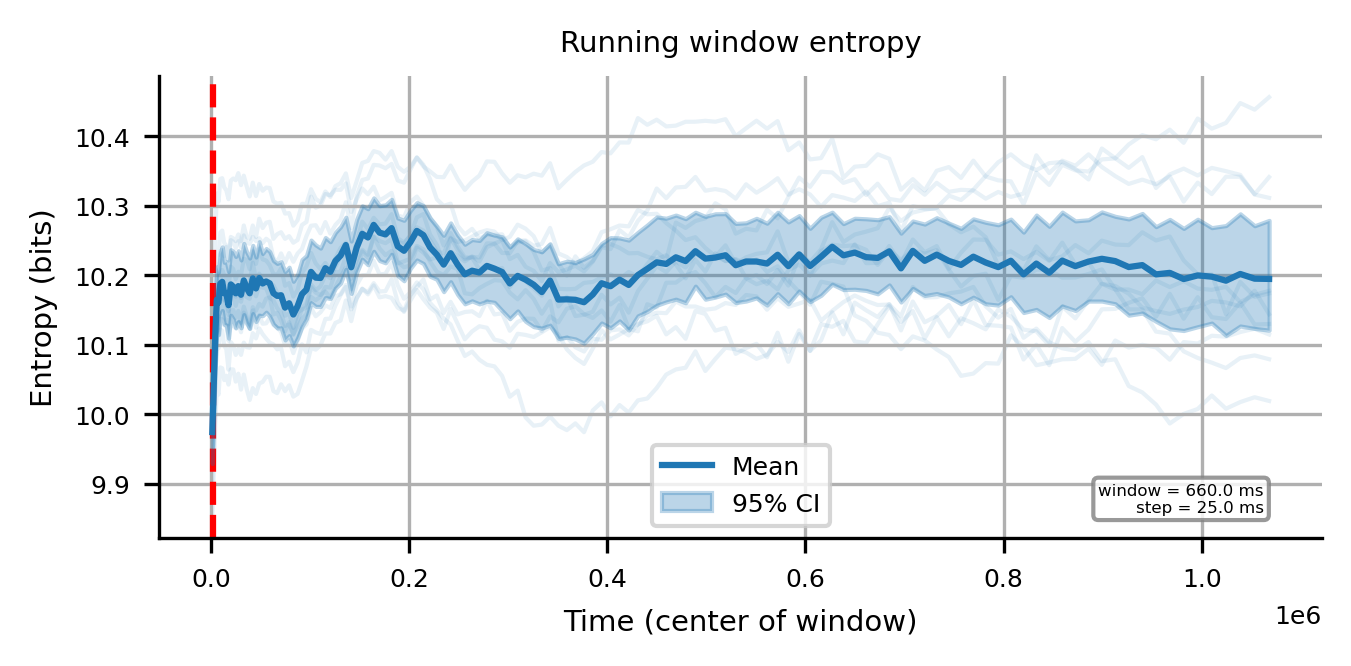

In [21]:
# Use the time axis from the first batch (assumes all aligned)
time_axis = post_batch_times[0][:max_len]
# Build the annotation string
params_text = f"window = {window_size*0.25:.1f} ms\nstep = {step_size*0.25:.1f} ms"

plt.figure(figsize=(5,2))

for batch in range(10):
    plt.plot(post_batch_times[batch], post_batch_entropies[batch], color='C0', alpha=0.1, zorder=0, linewidth=1)

plt.plot(time_axis, means, color='C0', label='Mean', zorder=9)
plt.fill_between(time_axis, cis_low, cis_high, color='C0', alpha=0.3, label='95% CI', zorder=8)

plt.xlabel("Time (center of window)")
plt.ylabel("Entropy (bits)")
plt.axvline(2000, color='red', linestyle='--')

# Put parameters in a text box inside the plot
plt.text(
    0.95, 0.05, params_text,
    transform=plt.gca().transAxes,   # relative to axes (0–1)
    ha='right', va='bottom',
    fontsize=4,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.3')
)

plt.title("Running window entropy")
plt.grid(True)
plt.legend()
plt.show()


In [22]:
# Determine time axis from number of timesteps
T_total = 2000*2
T = S_hist.shape[0]*2
dt = T_total / T
time_axis = np.arange(T) * dt


In [23]:
np.array(time_axis)*0.25

array([0.000000e+00, 6.250000e-02, 1.250000e-01, ..., 9.998125e+02,
       9.998750e+02, 9.999375e+02], shape=(16000,))

In [24]:
dt = 0.25
window_size_real_time = window_size*dt
step_size_real_time = step_size*dt

In [25]:
real_times = []
for start in range(0, A.shape[0]):
    print(start)
    real_times.append(real_times[-1] + (start + window_size_real_time//2) if real_times else (start + window_size_real_time//2))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [26]:
real_times

[330.0,
 661.0,
 993.0,
 1326.0,
 1660.0,
 1995.0,
 2331.0,
 2668.0,
 3006.0,
 3345.0,
 3685.0,
 4026.0,
 4368.0,
 4711.0,
 5055.0,
 5400.0,
 5746.0,
 6093.0,
 6441.0,
 6790.0,
 7140.0,
 7491.0,
 7843.0,
 8196.0,
 8550.0,
 8905.0,
 9261.0,
 9618.0,
 9976.0,
 10335.0,
 10695.0,
 11056.0,
 11418.0,
 11781.0,
 12145.0,
 12510.0,
 12876.0,
 13243.0,
 13611.0,
 13980.0,
 14350.0,
 14721.0,
 15093.0,
 15466.0,
 15840.0,
 16215.0,
 16591.0,
 16968.0,
 17346.0,
 17725.0,
 18105.0,
 18486.0,
 18868.0,
 19251.0,
 19635.0,
 20020.0,
 20406.0,
 20793.0,
 21181.0,
 21570.0,
 21960.0,
 22351.0,
 22743.0,
 23136.0,
 23530.0,
 23925.0,
 24321.0,
 24718.0,
 25116.0,
 25515.0,
 25915.0,
 26316.0,
 26718.0,
 27121.0,
 27525.0,
 27930.0,
 28336.0,
 28743.0,
 29151.0,
 29560.0,
 29970.0,
 30381.0,
 30793.0,
 31206.0,
 31620.0,
 32035.0,
 32451.0,
 32868.0,
 33286.0,
 33705.0,
 34125.0,
 34546.0,
 34968.0,
 35391.0,
 35815.0,
 36240.0,
 36666.0,
 37093.0,
 37521.0,
 37950.0,
 38380.0,
 38811.0,
 39243.0,
 3

In [27]:
real_times = []
dt = 0.25
window_size_real_time = window_size * dt
step_size_real_time = step_size * dt
for start in range(0, A.shape[0] - window_size + 1, step_size):
    real_times.append(window_size_real_time / 2 + step_size_real_time * start)

In [28]:
4000*4/2000

8.0

In [29]:
real_times

[330.0,
 2830.0,
 5330.0,
 7830.0,
 10330.0,
 12830.0,
 15330.0,
 17830.0,
 20330.0,
 22830.0,
 25330.0,
 27830.0,
 30330.0,
 32830.0,
 35330.0,
 37830.0,
 40330.0,
 42830.0,
 45330.0,
 47830.0,
 50330.0,
 52830.0,
 55330.0,
 57830.0,
 60330.0,
 62830.0,
 65330.0,
 67830.0,
 70330.0,
 72830.0,
 75330.0,
 77830.0,
 80330.0,
 82830.0,
 85330.0,
 87830.0,
 90330.0,
 92830.0,
 95330.0,
 97830.0,
 100330.0,
 102830.0,
 105330.0,
 107830.0,
 110330.0,
 112830.0,
 115330.0,
 117830.0,
 120330.0,
 122830.0,
 125330.0,
 127830.0,
 130330.0,
 132830.0,
 135330.0,
 137830.0,
 140330.0,
 142830.0,
 145330.0,
 147830.0,
 150330.0,
 152830.0,
 155330.0,
 157830.0,
 160330.0,
 162830.0,
 165330.0,
 167830.0,
 170330.0,
 172830.0,
 175330.0,
 177830.0,
 180330.0,
 182830.0,
 185330.0,
 187830.0,
 190330.0,
 192830.0,
 195330.0,
 197830.0,
 200330.0,
 202830.0,
 205330.0,
 207830.0,
 210330.0,
 212830.0,
 215330.0,
 217830.0,
 220330.0,
 222830.0,
 225330.0,
 227830.0,
 230330.0,
 232830.0,
 235330.0,
